In [1]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm

#for text pre-processing
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')

#for model-building
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score


# bag of words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer#for word embedding
import gensim
from gensim.models import Word2Vec

[nltk_data] Downloading package punkt to /home/francesco/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/francesco/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/francesco/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/francesco/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
all_files = []
for dirname, _, filenames in os.walk('/home/francesco/kaggle/input'):
    for filename in filenames:
        full_path=os.path.join(dirname, filename)
        all_files.append(full_path)
# files = [file for file in all_files if re.search(r'((2023(0[1-9]|1[0-2])(0[1-9]|[12][0-9]|3[01])))', file)]
files = [file for file in all_files if re.search(r'(FEB|MAR)', file)]
# files = [file for file in all_files if re.search(r'(FEB)', file)]
# files = all_files[:2]
files

['/home/francesco/kaggle/input/UkraineWar/UkraineWar/UkraineCombinedTweetsDeduped_MAR16.csv.gzip',
 '/home/francesco/kaggle/input/UkraineWar/UkraineWar/UkraineCombinedTweetsDeduped_MAR04.csv.gzip',
 '/home/francesco/kaggle/input/UkraineWar/UkraineWar/UkraineCombinedTweetsDeduped_MAR01.csv.gzip',
 '/home/francesco/kaggle/input/UkraineWar/UkraineWar/UkraineCombinedTweetsDeduped_FEB28_part1.csv.gzip',
 '/home/francesco/kaggle/input/UkraineWar/UkraineWar/UkraineCombinedTweetsDeduped_MAR10.csv.gzip',
 '/home/francesco/kaggle/input/UkraineWar/UkraineWar/UkraineCombinedTweetsDeduped_MAR31.csv.gzip',
 '/home/francesco/kaggle/input/UkraineWar/UkraineWar/UkraineCombinedTweetsDeduped_MAR12.csv.gzip',
 '/home/francesco/kaggle/input/UkraineWar/UkraineWar/UkraineCombinedTweetsDeduped_MAR15.csv.gzip',
 '/home/francesco/kaggle/input/UkraineWar/UkraineWar/UkraineCombinedTweetsDeduped_MAR19.csv.gzip',
 '/home/francesco/kaggle/input/UkraineWar/UkraineWar/UkraineCombinedTweetsDeduped_MAR09.csv.gzip',
 '/h

In [3]:
# Reading and Concatenating Multiple Compressed CSV Files into a Single DataFrame
tmp_df_list = []
for file in tqdm(files):
    # print(f"Reading in {file}")
    # unzip and read in the csv file as a dataframe
    tmp_df = pd.read_csv(file, compression="gzip", header=0, index_col=0)
    # append dataframe to temp list
    tmp_df_list.append(tmp_df)

  3%|▎         | 1/33 [00:04<02:11,  4.11s/it]/tmp/ipykernel_34398/3639286973.py:6: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  tmp_df = pd.read_csv(file, compression="gzip", header=0, index_col=0)
  9%|▉         | 3/33 [00:12<02:02,  4.09s/it]/tmp/ipykernel_34398/3639286973.py:6: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  tmp_df = pd.read_csv(file, compression="gzip", header=0, index_col=0)
 12%|█▏        | 4/33 [00:14<01:37,  3.35s/it]/tmp/ipykernel_34398/3639286973.py:6: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  tmp_df = pd.read_csv(file, compression="gzip", header=0, index_col=0)
 18%|█▊        | 6/33 [00:21<01:32,  3.42s/it]/tmp/ipykernel_34398/3639286973.py:6: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  tmp_df = pd.read_csv(file, compression="gz

In [4]:
print("Concatenating the DataFrames")
# concatenate the dataframes in the temp list row-wise
data = pd.concat(tmp_df_list, axis=0)
print("Concatenation complete!")

Concatenating the DataFrames
Concatenation complete!


In [5]:
data["usercreatedts"] = pd.to_datetime(data["usercreatedts"], format='mixed')
data["tweetcreatedts"] = pd.to_datetime(data["tweetcreatedts"], format='mixed')
data["extractedts"] = pd.to_datetime(data["extractedts"], format='mixed')
# data['clean_text'] = data['text'].apply(clean_text, emails=True)
data = data[data["tweetcreatedts"] <= '2022-03-05']
# data = data[data["tweetcreatedts"] < '2022-03-01']
# check dtypes
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2437581 entries, 1378357 to 982583
Data columns (total 17 columns):
 #   Column          Dtype         
---  ------          -----         
 0   userid          int64         
 1   username        object        
 2   acctdesc        object        
 3   location        object        
 4   following       int64         
 5   followers       int64         
 6   totaltweets     int64         
 7   usercreatedts   datetime64[ns]
 8   tweetid         int64         
 9   tweetcreatedts  datetime64[ns]
 10  retweetcount    int64         
 11  text            object        
 12  hashtags        object        
 13  language        object        
 14  coordinates     object        
 15  favorite_count  int64         
 16  extractedts     datetime64[ns]
dtypes: datetime64[ns](3), int64(7), object(7)
memory usage: 334.8+ MB


In [6]:
data.head()

,userid,username,acctdesc,location,following,followers,totaltweets,usercreatedts,tweetid,tweetcreatedts,retweetcount,text,hashtags,language,coordinates,favorite_count,extractedts
1378357,962159694046523392,CuttingEdgeDino,"Always thinking, -Let's Go Brandon!- #LGB",NaN,429,205,7624,2018-02-10 03:02:01,1499535089977282566,2022-03-04,0,@SenFeinstein you and your #oligarch cronies (...,"[{'text': 'oligarch', 'indices': [27, 36]}, {'...",en,NaN,0,2022-03-04 00:01:56.550039
1378358,1407899290790473732,SectionChine,"Infos sans préjugés sur la Chine, avec une dom...",NaN,1234,1223,162,2021-06-24 06:06:32,1499535090279272486,2022-03-04,0,La crise en #Ukraine a déplacé la stratégie du...,"[{'text': 'Ukraine', 'indices': [12, 20]}, {'t...",fr,NaN,0,2022-03-04 00:01:56.542631
1378359,770039615550021632,Valentinmsn2,Chtx/Angers,"Angers, France",282,244,9053,2016-08-28 23:25:26,1499535090505949186,2022-03-04,883,Vous doutez de notre force de dissuasion ? #Uk...,"[{'text': 'Ukraine', 'indices': [61, 69]}]",fr,NaN,0,2022-03-04 00:01:56.535210
1378360,952334892003680257,ShaunaO2011,NaN,NaN,1373,266,18115,2018-01-14 00:21:46,1499535090661134336,2022-03-04,1,Their bloods are on the Russian hands.\nMilita...,"[{'text': 'Mariupol', 'indices': [77, 86]}, {'...",en,NaN,0,2022-03-04 00:01:56.527344
1378361,1496695221366759427,thewelshtudor,"Pub quiz aficionado. Beer, whisky, BBQ enthusi...","Manchester, England",20,12,809,2022-02-24 03:55:38,1499535090677948419,2022-03-04,265,9:32 pm in #Ukraine. \n\nMy colleague from Sum...,"[{'text': 'Ukraine', 'indices': [30, 38]}]",en,NaN,0,2022-03-04 00:01:56.519788


In [7]:
data = data[['tweetid', 'tweetcreatedts', 'language', 'location', 'text', 'hashtags']]
data = data[data['language'] == 'en']

# data = data.head(10000)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1592592 entries, 1378357 to 982582
Data columns (total 6 columns):
 #   Column          Non-Null Count    Dtype         
---  ------          --------------    -----         
 0   tweetid         1592592 non-null  int64         
 1   tweetcreatedts  1592592 non-null  datetime64[ns]
 2   language        1592592 non-null  object        
 3   location        928502 non-null   object        
 4   text            1592592 non-null  object        
 5   hashtags        1592592 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 85.1+ MB


In [8]:
# import these modules
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

ps = PorterStemmer()

#convert to lowercase, strip and remove punctuations
def preprocess(text):
    text = text.lower() 
    text=text.strip()  
    text=re.compile('<.*?>').sub('', text) 
    text = re.sub(r'http\S+', ' ', text)
    text = re.sub(r'&', 'and', text)
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)  
    text = re.sub('\s+', ' ', text)  
    text = re.sub(r't\.co\S+', ' ', text)
    text = re.sub(r'\[[0-9]*\]',' ',text) 
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d',' ',text) 
    text = re.sub(r'\s+',' ',text) 
    text = ps.stem(text)
    return text
 
# STOPWORD REMOVAL
def stopword(string):
    a= [i for i in string.split() if i not in stopwords.words('english')]
    return ' '.join(a)#LEMMATIZATION
# Initialize the lemmatizer
wl = WordNetLemmatizer()
 
# This is a helper function to map NTLK position tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN# Tokenize the sentence
def lemmatizer(string):
    word_pos_tags = nltk.pos_tag(word_tokenize(string)) # Get position tags
    a=[wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)] # Map the position tag and lemmatize the word/token
    return " ".join(a)


In [9]:
def finalpreprocess(string):
    return lemmatizer(stopword(preprocess(string)))
    
data['clean_text'] = data['text'].apply(lambda x: finalpreprocess(x))
data.head()

,tweetid,tweetcreatedts,language,location,text,hashtags,clean_text
1378357,1499535089977282566,2022-03-04,en,NaN,@SenFeinstein you and your #oligarch cronies (...,"[{'text': 'oligarch', 'indices': [27, 36]}, {'...",senfeinstein oligarch crony r guilty war crime...
1378360,1499535090661134336,2022-03-04,en,NaN,Their bloods are on the Russian hands.\nMilita...,"[{'text': 'Mariupol', 'indices': [77, 86]}, {'...",blood russian hand military hospital mariupol ...
1378361,1499535090677948419,2022-03-04,en,"Manchester, England",9:32 pm in #Ukraine. \n\nMy colleague from Sum...,"[{'text': 'Ukraine', 'indices': [30, 38]}]",pm ukraine colleague sumy name daryna leave he...
1378363,1499535091202236417,2022-03-04,en,NaN,#ICYMI: Loud applause resounded in the #UN Gen...,"[{'text': 'ICYMI', 'indices': [0, 6]}, {'text'...",icymi loud applause resound un general assembl...
1378365,1499535091655192579,2022-03-04,en,"Brooklyn, NY",I’m donating 3 x signed A3 prints for #PhotoPr...,"[{'text': 'PhotoPrintDay', 'indices': [57, 71]}]",im donate x sign print photoprintday friday th...


WordCloud:


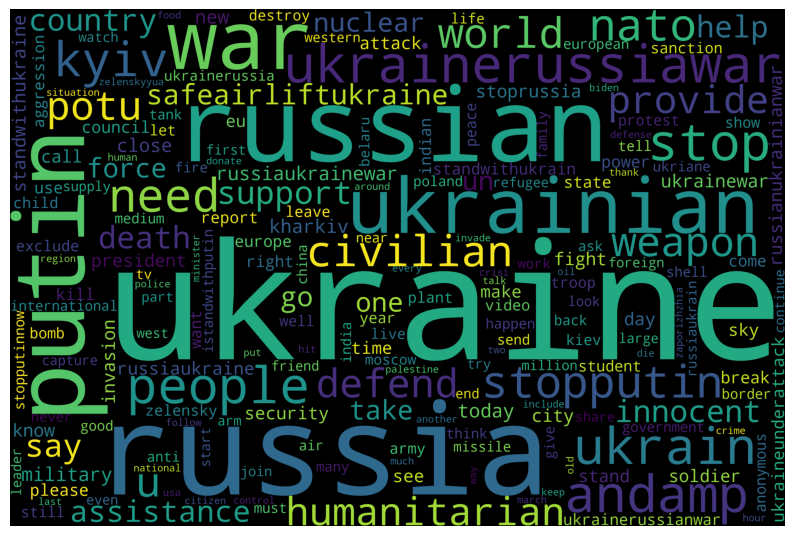

In [47]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

corpus = data["clean_text"].tolist()


print("WordCloud:")
wordcloud1 = WordCloud(width = 3000, height = 2000, collocations=False, stopwords = STOPWORDS).generate(" ".join(corpus))
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud1) 
plt.axis("off")
plt.show()


In [48]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1592592 entries, 1378357 to 982582
Data columns (total 6 columns):
 #   Column          Non-Null Count    Dtype         
---  ------          --------------    -----         
 0   tweetcreatedts  1592592 non-null  datetime64[ns]
 1   language        1592592 non-null  object        
 2   location        928502 non-null   object        
 3   text            1592592 non-null  object        
 4   hashtags        1592592 non-null  object        
 5   clean_text      1592592 non-null  object        
dtypes: datetime64[ns](1), object(5)
memory usage: 85.1+ MB


In [11]:
data.to_parquet('df.parquet.gzip', compression='gzip')

/home/francesco/anaconda3/envs/NLP3/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


In [12]:
data = pd.read_parquet('df.parquet.gzip')
data = data[data["tweetcreatedts"] < '2022-03-01']

data.head()

,tweetcreatedts,language,location,text,hashtags,clean_text
1498818,2022-02-28 00:07:06,en,None,#Moscow: Vladimir Putin visited the constructi...,"[{'text': 'Moscow', 'indices': [21, 28]}]",moscow vladimir putin visit construction site ...
1498820,2022-02-28 00:07:06,en,None,I will be filing a bill to sanction &amp; issu...,"[{'text': 'Ukraine', 'indices': [109, 117]}]",file bill sanction andamp issue lifetime visa ...
1498822,2022-02-28 00:07:06,en,United States,⚡️New York State Governor Kathy Hokul (Democra...,"[{'text': 'Russia', 'indices': [132, 139]}]",new york state governor kathy hokul democrat s...
1498824,2022-02-28 00:07:07,en,Polska,SOUND ON.\n\nThis is what our every night look...,"[{'text': 'Kyiv', 'indices': [73, 78]}, {'text...",sound every night look like kyiv ukraine ring ...
1498825,2022-02-28 00:07:07,en,"Port Coquitlam, BC, Canada","""Ukrainian soldiers spot freezing puppy alone ...",[],ukrainian soldier spot freeze puppy alone outs...


In [5]:
import ast

# Define a safe function to convert string to actual list of dictionaries
def string_to_list(hashtags_str):
    try:
        # This safely evaluates the string as a Python literal
        return ast.literal_eval(str(hashtags_str))
    except ValueError:
        # In case there is an issue with string formatting return empty list
        return []
    
# Step 1: Extract and explode hashtags
def extract_hashtags(hashtags_list):
    # Extracts the 'text' from each hashtag dictionary in the list
    return set([hashtag['text'].lower() for hashtag in hashtags_list])

data['hashtags'] = data['hashtags'].apply(string_to_list)
print(f'Reduced hashtags to lists')
data['hashtags_text'] = data['hashtags'].apply(extract_hashtags)

Reduced hashtags to lists


In [11]:
from textblob import TextBlob

# Step 2: Perform sentiment analysis
def get_sentiment(text):
    # This function returns the polarity score of the text
    return TextBlob(text).sentiment.polarity

data_exploded = data.explode('hashtags_text')
data_exploded = data_exploded.dropna(subset='hashtags_text').drop(columns='hashtags')

# Apply the sentiment analysis function to the text column
data_exploded['sentiment'] = data_exploded['clean_text'].apply(get_sentiment)

data_exploded.head()

,language,location,text,clean_text,hashtags_text,sentiment
1498818,en,NaN,#Moscow: Vladimir Putin visited the constructi...,moscow vladimir putin visit construction site ...,moscow,0.000000
1498820,en,NaN,I will be filing a bill to sanction &amp; issu...,file bill sanction andamp issue lifetime visa ...,ukraine,0.000000
1498822,en,United States,⚡️New York State Governor Kathy Hokul (Democra...,new york state governor kathy hokul democrat s...,russia,0.136364
1498824,en,Polska,SOUND ON.\n\nThis is what our every night look...,sound every night look like kyiv ukraine ring ...,kyiv,0.100000
1498824,en,Polska,SOUND ON.\n\nThis is what our every night look...,sound every night look like kyiv ukraine ring ...,ukraine,0.100000


In [12]:
# Step 3: Group by hashtag and calculate average
average_sentiment_per_hashtag = data_exploded.groupby('hashtags_text').agg({'hashtags_text': 'count', 'sentiment': 'mean'}).rename(columns={'hashtags_text': 'N', 'sentiment': 'mean_semt'}).reset_index()

# Rename the columns for clarity
# average_sentiment_per_hashtag.columns = ['Hashtag', 'Average_Sentiment']
average_sentiment_per_hashtag

,hashtags_text,N,mean_semt
0,100daysofcode,1,-0.291667
1,1trillion,7,0.305195
2,27february,1,0.000000
3,3guerramundial,1,-0.038462
4,60minutes,1,0.000000
...,...,...,...
2014,روسيا,3,-0.260606
2015,كيريل_بيتكوف,1,0.400000
2016,موسكو,1,-0.500000
2017,ウクライナ,1,-0.250000


In [13]:
import pandas as pd
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch
from torch.nn.functional import softmax

# Function for sentiment analysis on a single text
def sentiment_analysis(text, model, tokenizer):
    # Preprocess text
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)

    # Perform inference
    with torch.no_grad():
        logits = model(**inputs).logits

    # Convert logits to probabilities
    probabilities = softmax(logits, dim=1).flatten().tolist()

    # Extract scores for each sentiment
    return {label: score for label, score in zip(model.config.id2label.values(), probabilities)}

# Function to handle batch processing
def batch_sentiment_analysis(texts, model, tokenizer, batch_size=16):
    results = []
    for i in tqdm(range(0, len(texts), batch_size)):
        batch_texts = texts[i:i+batch_size]
        batch_results = [sentiment_analysis(text, model, tokenizer) for text in batch_texts]
        results.extend(batch_results)
    return results

# Load model and tokenizer
model_name = "michellejieli/emotion_text_classifier"
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Example DataFrame
# data = {'text': ["I love this!", "I hate this!", ...]}  # Replace with your data
# df = pd.DataFrame(data)

# Apply the batch sentiment analysis function
data['sentiment_scores'] = batch_sentiment_analysis(data['clean_text'].tolist(), model, tokenizer, batch_size=100)

# Display the DataFrame
print(data)


100%|██████████| 4692/4692 [2:34:47<00:00,  1.98s/it]  

             tweetcreatedts language                      location  \
1498818 2022-02-28 00:07:06       en                          None   
1498820 2022-02-28 00:07:06       en                          None   
1498822 2022-02-28 00:07:06       en                 United States   
1498824 2022-02-28 00:07:07       en                        Polska   
1498825 2022-02-28 00:07:07       en    Port Coquitlam, BC, Canada   
...                     ...      ...                           ...   
140376  2022-02-28 23:31:22       en        San Francisco Bay Area   
140377  2022-02-28 23:31:22       en  Krefeld, Nordrhein-Westfalen   
140378  2022-02-28 23:31:22       en                    Manchester   
140379  2022-02-28 23:31:22       en              Perth, Australia   
140382  2022-02-28 23:31:22       en                        Oregon   

                                                      text  \
1498818  #Moscow: Vladimir Putin visited the constructi...   
1498820  I will be filing a bill to

In [1]:
data.head()

NameError: name 'data' is not defined

In [ ]:

# Convert sentiment_scores column to a DataFrame
sentiment_df = pd.json_normalize(data['sentiment_scores'])

# Concatenate the new DataFrame with the original DataFrame
result_df = pd.concat([data, sentiment_df], axis=1).drop(columns=['sentiment_scores'])


In [3]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch
from torch.nn.functional import softmax

# Load model and tokenizer
model_name = "michellejieli/emotion_text_classifier"  # replace with your model name
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Text to classify
text = "You are so great! I am really excited to be here!"

# Preprocess text
inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)

# Perform inference
with torch.no_grad():
    logits = model(**inputs).logits

# Convert logits to probabilities
probabilities = softmax(logits, dim=1)

# Extract scores for each sentiment
scores = probabilities.flatten().tolist()
sentiment_scores = {label: score for label, score in zip(model.config.id2label.values(), scores)}

print(sentiment_scores)

{'anger': 0.0005671648541465402, 'disgust': 0.0001580435928190127, 'fear': 0.00041082777897827327, 'joy': 0.9921981692314148, 'neutral': 0.004227140918374062, 'sadness': 0.0002603758475743234, 'surprise': 0.0021782151889055967}


In [7]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, pipeline

# Load the model and tokenizer
model_name = "distilbert-base-uncased-finetuned-sst-2-english"  # Example model
model_name = "michellejieli/emotion_text_classifier"  # Example model
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Create a pipeline for sentiment analysis
sentiment_pipeline = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

# Define a function to perform sentiment analysis
def sentiment_analysis(text, model, tokenizer):
    # Preprocess text
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)

    # Perform inference
    with torch.no_grad():
        logits = model(**inputs).logits

    # Convert logits to probabilities
    probabilities = softmax(logits, dim=1)

    # Extract scores for each sentiment
    scores = probabilities.flatten().tolist()
    return {label: score for label, score in zip(model.config.id2label.values(), scores)}


2023-11-17 11:21:36.888187: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-17 11:21:37.044667: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-17 11:21:37.666800: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [8]:
# Batch size depends on your memory; you might need to adjust this
batch_size = 200
results = []

for i in tqdm(range(0, len(data['clean_text']), batch_size)):
    batch = data['clean_text'][i:i+batch_size].tolist()
    batch_predictions = sentiment_pipeline(batch)
    results.extend(batch_predictions)

100%|██████████| 7963/7963 [9:38:45<00:00,  4.36s/it]   


In [9]:

# Add the results to your DataFrame
data['sentiment'] = [result['label'] for result in results]
data['sentiment_score'] = [result['score'] for result in results]

In [17]:
data.head(20)

,language,location,text,hashtags,clean_text,hashtags_text,sentiment,sentiment_score
1498818,en,NaN,#Moscow: Vladimir Putin visited the constructi...,"[{'text': 'Moscow', 'indices': [21, 28]}]",moscow vladimir putin visit construction site ...,{moscow},neutral,0.944002
1498820,en,NaN,I will be filing a bill to sanction &amp; issu...,"[{'text': 'Ukraine', 'indices': [109, 117]}]",file bill sanction andamp issue lifetime visa ...,{ukraine},neutral,0.399826
1498822,en,United States,⚡️New York State Governor Kathy Hokul (Democra...,"[{'text': 'Russia', 'indices': [132, 139]}]",new york state governor kathy hokul democrat s...,{russia},neutral,0.892542
1498824,en,Polska,SOUND ON.\n\nThis is what our every night look...,"[{'text': 'Kyiv', 'indices': [73, 78]}, {'text...",sound every night look like kyiv ukraine ring ...,"{kyiv, ukraine}",neutral,0.703704
1498825,en,"Port Coquitlam, BC, Canada","""Ukrainian soldiers spot freezing puppy alone ...",[],ukrainian soldier spot freeze puppy alone outs...,{},neutral,0.819719
1498827,en,"Wirral, Merseyside, UK",Closer look at the Vasylkiv oil depot fire whi...,"[{'text': 'osint', 'indices': [118, 124]}, {'t...",closer look vasylkiv oil depot fire occur last...,"{osint, russia}",neutral,0.417182
1498828,en,North East USA,#Russia's state media is flipping out over our...,"[{'text': 'Russia', 'indices': [20, 27]}]",russia state medium flip late sanction know li...,{russia},neutral,0.498508
1498829,en,"Michigan, USA",No matter what happens militarily #Putin won’t...,"[{'text': 'Putin', 'indices': [50, 56]}]",matter happen militarily putin wont win goal g...,{putin},anger,0.517238
1498830,en,"Baltimore, MD","In #Novosibirsk, #Russia, local residents are ...","[{'text': 'Novosibirsk', 'indices': [22, 34]},...",novosibirsk russia local resident march protes...,"{protest, russia, ukraine, novosibirsk}",fear,0.365036
1498832,en,"New Forest, UK",Ireland to close its airspace to Russian air t...,"[{'text': 'ireland', 'indices': [66, 74]}, {'t...",ireland close airspace russian air traffic ire...,"{ireland, aviation, travelwarning, russia}",neutral,0.684860


In [10]:
data.to_parquet('df_sentiment.parquet.gzip', compression='gzip')

/home/francesco/anaconda3/envs/NLP/lib/python3.11/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


In [18]:
data_exploded = data.explode('hashtags_text')
data_exploded = data_exploded.dropna(subset='hashtags_text').drop(columns='hashtags')


In [19]:
data_exploded

,language,location,text,clean_text,hashtags_text,sentiment,sentiment_score
1498818,en,NaN,#Moscow: Vladimir Putin visited the constructi...,moscow vladimir putin visit construction site ...,moscow,neutral,0.944002
1498820,en,NaN,I will be filing a bill to sanction &amp; issu...,file bill sanction andamp issue lifetime visa ...,ukraine,neutral,0.399826
1498822,en,United States,⚡️New York State Governor Kathy Hokul (Democra...,new york state governor kathy hokul democrat s...,russia,neutral,0.892542
1498824,en,Polska,SOUND ON.\n\nThis is what our every night look...,sound every night look like kyiv ukraine ring ...,kyiv,neutral,0.703704
1498824,en,Polska,SOUND ON.\n\nThis is what our every night look...,sound every night look like kyiv ukraine ring ...,ukraine,neutral,0.703704
...,...,...,...,...,...,...,...
1513482,en,WA,Moscow underground. Sometimes the act of resis...,moscow underground sometimes act resistance do...,ukriane,fear,0.499461
1513482,en,WA,Moscow underground. Sometimes the act of resis...,moscow underground sometimes act resistance do...,kyiv,fear,0.499461
1513484,en,Kaohsiung，Taiwan,Ukrainian drones destroy a Russian military co...,ukrainian drone destroy russian military convo...,glorytoukraine,neutral,0.807583
1513484,en,Kaohsiung，Taiwan,Ukrainian drones destroy a Russian military co...,ukrainian drone destroy russian military convo...,ukrainerussiawar,neutral,0.807583


In [25]:
sentiment_by_hashtag = data_exploded.groupby(by =['hashtags_text', 'sentiment']).agg({'hashtags_text': 'count', 'sentiment_score': 'mean'}).rename(columns={'hashtags_text': 'N', 'sentiment_score': 'avg_sentiment'}).reset_index().rename(columns={'hashtags_text': 'hashtag'})

In [28]:
sentiment_by_hashtag.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2761 entries, 0 to 2760
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   hashtag        2761 non-null   object 
 1   sentiment      2761 non-null   object 
 2   N              2761 non-null   int64  
 3   avg_sentiment  2761 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 86.4+ KB


In [32]:
sentiment_by_hashtag['N_total'] = sentiment_by_hashtag.groupby('hashtag')['N'].transform('sum')
sentiment_by_hashtag['sentiment_pct'] = sentiment_by_hashtag['N'] / sentiment_by_hashtag['N_total']

sentiment_by_hashtag

,hashtag,sentiment,N,avg_sentiment,sentiment_pct,N_total
0,100daysofcode,neutral,1,0.698727,1.000000,1
1,1trillion,joy,6,0.536748,0.857143,7
2,1trillion,neutral,1,0.873695,0.142857,7
3,27february,neutral,1,0.883501,1.000000,1
4,3guerramundial,neutral,1,0.793368,1.000000,1
...,...,...,...,...,...,...
2756,روسيا,neutral,2,0.622424,0.666667,3
2757,كيريل_بيتكوف,anger,1,0.725434,1.000000,1
2758,موسكو,neutral,1,0.625127,1.000000,1
2759,ウクライナ,joy,1,0.510181,1.000000,1


In [11]:
pd.read_parquet('df_sentiment.parquet.gzip')


,tweetcreatedts,language,location,text,hashtags,clean_text,sentiment,sentiment_score
1378357,2022-03-04 00:00:00,en,None,@SenFeinstein you and your #oligarch cronies (...,"[{'text': 'oligarch', 'indices': [27, 36]}, {'...",senfeinstein oligarch crony r guilty war crime...,anger,0.957364
1378360,2022-03-04 00:00:00,en,None,Their bloods are on the Russian hands.\nMilita...,"[{'text': 'Mariupol', 'indices': [77, 86]}, {'...",blood russian hand military hospital mariupol ...,neutral,0.935565
1378361,2022-03-04 00:00:00,en,"Manchester, England",9:32 pm in #Ukraine. \n\nMy colleague from Sum...,"[{'text': 'Ukraine', 'indices': [30, 38]}]",pm ukraine colleague sumy name daryna leave he...,sadness,0.568508
1378363,2022-03-04 00:00:00,en,None,#ICYMI: Loud applause resounded in the #UN Gen...,"[{'text': 'ICYMI', 'indices': [0, 6]}, {'text'...",icymi loud applause resound un general assembl...,joy,0.863716
1378365,2022-03-04 00:00:00,en,"Brooklyn, NY",I’m donating 3 x signed A3 prints for #PhotoPr...,"[{'text': 'PhotoPrintDay', 'indices': [57, 71]}]",im donate x sign print photoprintday friday th...,joy,0.832781
...,...,...,...,...,...,...,...,...
982578,2022-03-02 23:59:55,en,"Massachusetts, USA",A third and fourth explosion have now been hea...,"[{'text': 'Kyiv', 'indices': [72, 77]}]",third fourth explosion hear near kyiv metro st...,fear,0.693758
982579,2022-03-02 23:59:56,en,None,@PeaceInuToken\nThis the #BSCGem of 2022\n💸Pri...,"[{'text': 'BSCGem', 'indices': [45, 52]}]",peaceinutoken bscgem private sale live pre sal...,joy,0.722992
982580,2022-03-02 23:59:56,en,"Vancouver, British Columbia",Kharkiv residents are ready to give a warm wel...,"[{'text': 'StopWarInUkraine', 'indices': [84, ...",kharkiv resident ready give warm welcome occup...,neutral,0.956323
982581,2022-03-02 23:59:56,en,"East Coast, USA",Two of the largest explosions I’ve ever experi...,"[{'text': 'kyiv', 'indices': [85, 90]}]",two large explosion ive ever experience go kyiv,neutral,0.673195
